<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/CCAP_UNET_HI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture using geospatial data

**Author:** [aaboettcher](https://spectral.online)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2021/02/28<br>
**Description:** Image segmentation model trained from scratch on the Colorado landcover dataset.<br>
**Attribution:** This script was adapted from the [Oxford Pets Image Segmentation Notebook](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/oxford_pets_image_segmentation.ipynb#scrollTo=YDU52y_UQ4P0) and inspired by this [github repo](https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation). The imagery and label data in their original form can be found [here](https://drcog.org/services-and-resources/data-maps-and-modeling/regional-land-use-land-cover-project) and [here](https://drcog.org/services-and-resources/data-maps-and-modeling/denver-regional-aerial-photography-project).

## Download the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown
import gdown
import zipfile
import os

# I switched to pngs and jpgs to try and use tensorflows native vectorization
#todo: get gdal working so you can just use geotiff
url = 'https://drive.google.com/uc?id=1SfjV4rwnK49hCf-zJBktcLdGd_1otKu2'
output = 'colorado_land_use_png.zip'

gdown.download(url,output,quiet = False)


cwd = os.getcwd()
with zipfile.ZipFile(cwd+'/colorado_land_use_png.zip', 'r') as zip_ref:
    zip_ref.extractall(cwd+'/sample_data')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1SfjV4rwnK49hCf-zJBktcLdGd_1otKu2
To: /content/colorado_land_use_png.zip
100%|██████████| 32.7M/32.7M [00:01<00:00, 28.3MB/s]


## Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = cwd+'/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR'
target_dir = cwd+'/sample_data/colorado_land_use_png_jpg_simplified/training/labels'

# input_dir = "images/"
# target_dir = "annotations/trimaps/"

img_size = (640, 640)
num_classes = 3
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 512
/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/3136260_1681980.jpg | /content/sample_data/colorado_land_use_png_jpg_simplified/training/labels/3136260_1681980.png
/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/3136260_1682132.jpg | /content/sample_data/colorado_land_use_png_jpg_simplified/training/labels/3136260_1682132.png
/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/3136260_1682284.jpg | /content/sample_data/colorado_land_use_png_jpg_simplified/training/labels/3136260_1682284.png
/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/3136260_1682436.jpg | /content/sample_data/colorado_land_use_png_jpg_simplified/training/labels/3136260_1682436.png
/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/3136260_1682588.jpg | /content/sample_data/colorado_land_use_png_jpg_simplified/training/labels/3136260_1682588.png
/content/sample_data/colora

## What does one input image and corresponding segmentation mask look like?

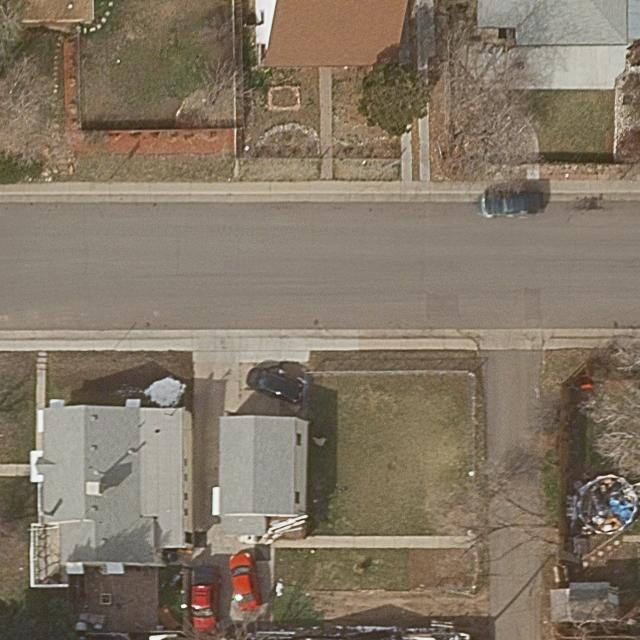

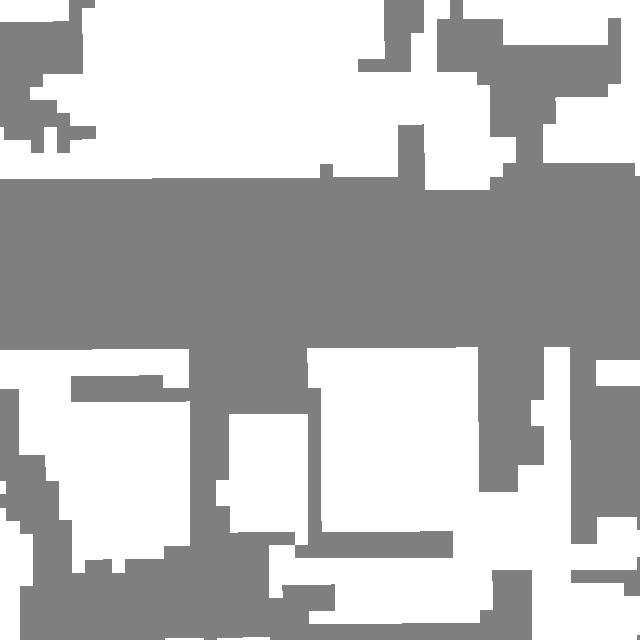

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[150]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[150]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class LandCover(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            # print(img)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Perpare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 8

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = LandCover(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
print(train_gen[0][1][0])
val_gen = LandCover(batch_size, img_size, val_input_img_paths, val_target_img_paths)

[[[0]
  [0]
  [0]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [2]
  [2]
  [2]]

 [[0]
  [0]
  [0]
  ...
  [2]
  [2]
  [2]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

# opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer="rmsprop")

callbacks = [
    keras.callbacks.ModelCheckpoint("landcover_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 16

model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/16
504/504 [==============================] - 169s 265ms/step - loss: 1.0936 - val_loss: 1.5450


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/16
504/504 [==============================] - 133s 263ms/step - loss: 0.7314 - val_loss: 0.8405
Epoch 3/16
504/504 [==============================] - 133s 264ms/step - loss: 0.6506 - val_loss: 1.3739
Epoch 4/16
504/504 [==============================] - 133s 263ms/step - loss: 0.6082 - val_loss: 0.7766
Epoch 5/16
504/504 [==============================] - 133s 263ms/step - loss: 0.5720 - val_loss: 0.6340
Epoch 6/16
504/504 [==============================] - 133s 264ms/step - loss: 0.5441 - val_loss: 0.9416
Epoch 7/16
504/504 [==============================] - 133s 264ms/step - loss: 0.5218 - val_loss: 0.9106
Epoch 8/16
504/504 [==============================] - 133s 264ms/step - loss: 0.4903 - val_loss: 1.1221
Epoch 9/16
504/504 [==============================] - 133s 263ms/step - loss: 0.4746 - val_loss: 0.6747
Epoch 10/16
504/504 [==============================] - 133s 264ms/step - loss: 0.4557 - val_loss: 0.7393
Epoch 11/16
504/504 [==============================] - 133s 264

KeyboardInterrupt: ignored

## Visualize predictions

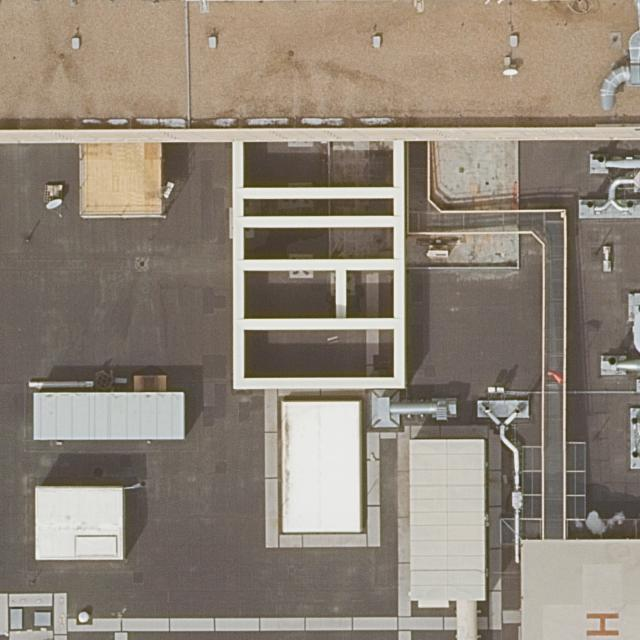

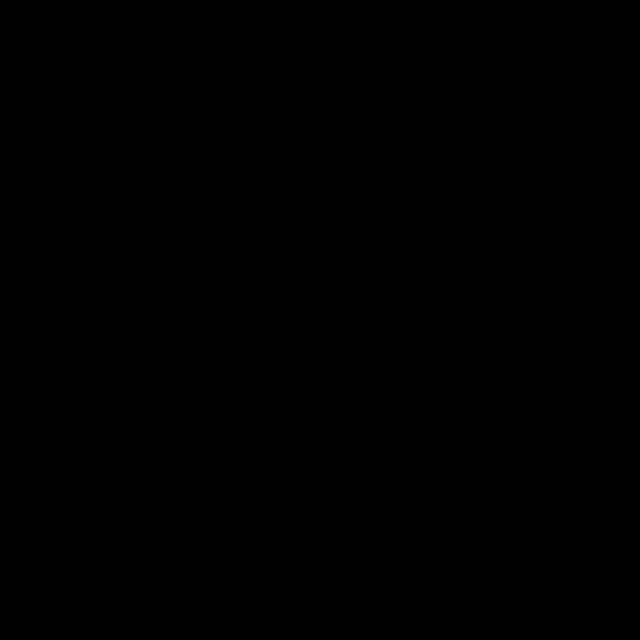

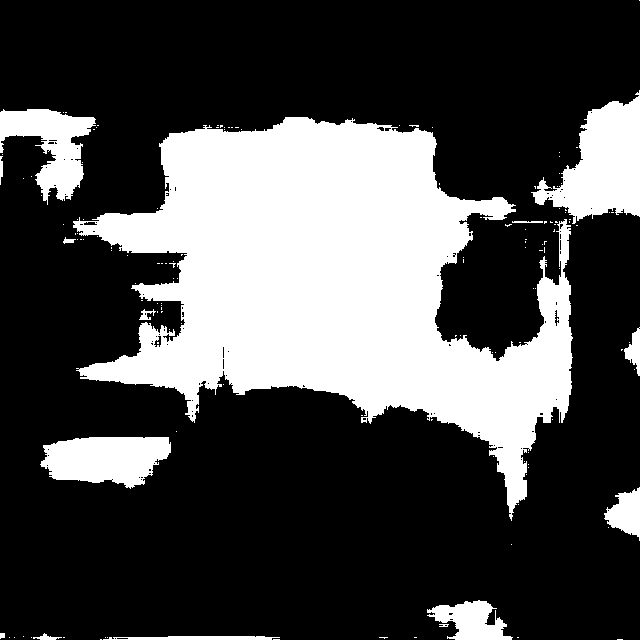

In [ ]:
# Generate predictions for all images in the validation set
from shutil import copyfile
val_gen = LandCover(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)



def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

def return_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return(img)

# Display results for validation image #10
i = 3

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
## When you are ready to generate a large quantity of predicts...
# all_gen = LandCover(batch_size, img_size, input_img_paths, input_img_paths)
# all_preds = model.predict(all_gen)

# for j in range(len(input_img_paths)):
#   # all_gen = LandCover(1, img_size, i,  i)
#   # all_preds = model.predict(all_gen)
#   i = input_img_paths[j]
#   mask = np.argmax(all_preds[j], axis=-1)
#   mask = np.expand_dims(mask, axis=-1)
#   img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#   # print(i)
#   # display(img)
#   out_path = i.replace("/content/sample_data/colorado_land_use_png_jpg_simplified/training/rgbNIR/", "/content/drive/MyDrive/Predictions/")

#   in_path_xml = i.replace(".jpg", ".jpg.aux.xml")

#   out_path_img = out_path.replace(".jpg", ".png")
#   out_path_xml = out_path.replace(".jpg", ".png.aux.xml")


#   # print(i)
#   # print(in_path_xml)


#   # print(out_path_img)
#   # print(out_path_xml)
#   copyfile(in_path_xml, out_path_xml)
#   img.save(out_path_img)